In [1]:
import serial
import time

import matplotlib.pyplot as plt
from surya.debug.render_html import filepath
# %config InlineBackend.figure_formats = ['svg']

from analysis_lib import KeysightInfiniiVisionMSO, DEFAULT_LABELS
from analysis_lib.decoder import RawDecoder, RawDecodeResult, RawFrame, BrotherSerialDecoder, BrotherDecodeResult, DecodedByte
from analysis_lib.plotting import plot_digital, plot_digital_normalized
from analysis_lib.capture import Capture

ADDRESS = "USB0::2391::5925::MY49110266::INSTR"

INTERFACE = "IF60"
TYPEWRITER = "AX20"
KEYBOARD = 1 # Typenrad Selection Switch: 1=LOCAL, 2=INTERNATIONAL, 3=SYMBOL

switches = [
    0,  # 1-1: UP=RS-232C, DOWN=CDCC interface
    0,  # 1-2: UP=Terminal mode, DOWN=Printer mode
    1,  # 1-3: USA users can ignore
    1,  # 1-4: UP=ASCII Wheel, DOWN=Non-ASCII Wheel
    1,  # 1-5: UP=12-inch paper, DOWN=11-inch paper
    1,  # 1-6: UP=Auto skip perforation, DOWN=Non auto skip
        #
    1,  # 2-1: UP=Local echo (half-duplex), DOWN=No echo (full-duplex)
    1,  # 2-2: UP=DC-1/DC-3 disabled, DOWN=enabled
    1,  # 2-3: UP=Auto line feed off, DOWN=double spacing
    1,  # 2-4: UP=7-bit data, DOWN=8-bit data
    1,  # 2-5: UP=Even parity, DOWN=Odd parity
        #
    1,  # 2-6:  DOWN    DOWN    DOWN    DOWN    UP      UP      UP      UP
    1,  # 2-7:  DOWN    DOWN    UP      UP      DOWN    DOWN    UP      UP
    1,  # 2-8:  DOWN    UP      DOWN    UP      DOWN    UP      DOWN    UP
        # BAUD  9600    4800    2400    1200    600     300     150     110
]

DIP_SWITCHES = sum(bit << i for i, bit in enumerate(switches))

def setup_scope(time_scale=1.5e-4, delay=4.5e-4, trigger_channel=4, trigger_slope="NEGative"):
    """
    Quick scope setup for notebook use
    """
    scope = KeysightInfiniiVisionMSO(ADDRESS)

    scope.setup_digital_channels(
        channels=range(6),
        threshold=2.5,
        time_scale=time_scale,
    )

    for i, label in enumerate(DEFAULT_LABELS):
        scope.set_digital_label(i, label)

    scope.setup_digital_trigger(channel=trigger_channel, slope=trigger_slope)
    scope.set_trigger_delay(delay)

    return scope

Connected to: AGILENT TECHNOLOGIES,MSO7014A,MY49110266,06.20.0000
Digital channels [0, 1, 2, 3, 4, 5] enabled, threshold=2.5V
Edge trigger on D4, slope=NEGative
Connection closed

Capture: SELECT
Timestamp: 2026-01-26 18:46:48
Devices: AX20 / IF60
Data: 400.00 MHz, Channels: 0:SI, 1:SO, 2:SCK, 3:KBACK, 4:READY, 5:KBRQ, 6:D6, 7:D7
Notes: Handshake between IF60 and AX20, after Transmission of DC1(Activates SEL Mode) from PC to Interface
Saved to: signal_captures/AX20_IF60/AX20_IF60_DESELECT.pkl

RAW-SI: 0b11111001, 0b11111101, 0b01111111, 0b11110100, 0b10110001, 0b10110001
RAW-SO: 0b00000000, 0b00000000, 0b00000100, 0b00000000, 0b00000000, 0b00000000
DEC-SI: ACK,STX,DEL,VT,N,N
DEC-SO: NUL,NUL,EOT,NUL,NUL,NUL


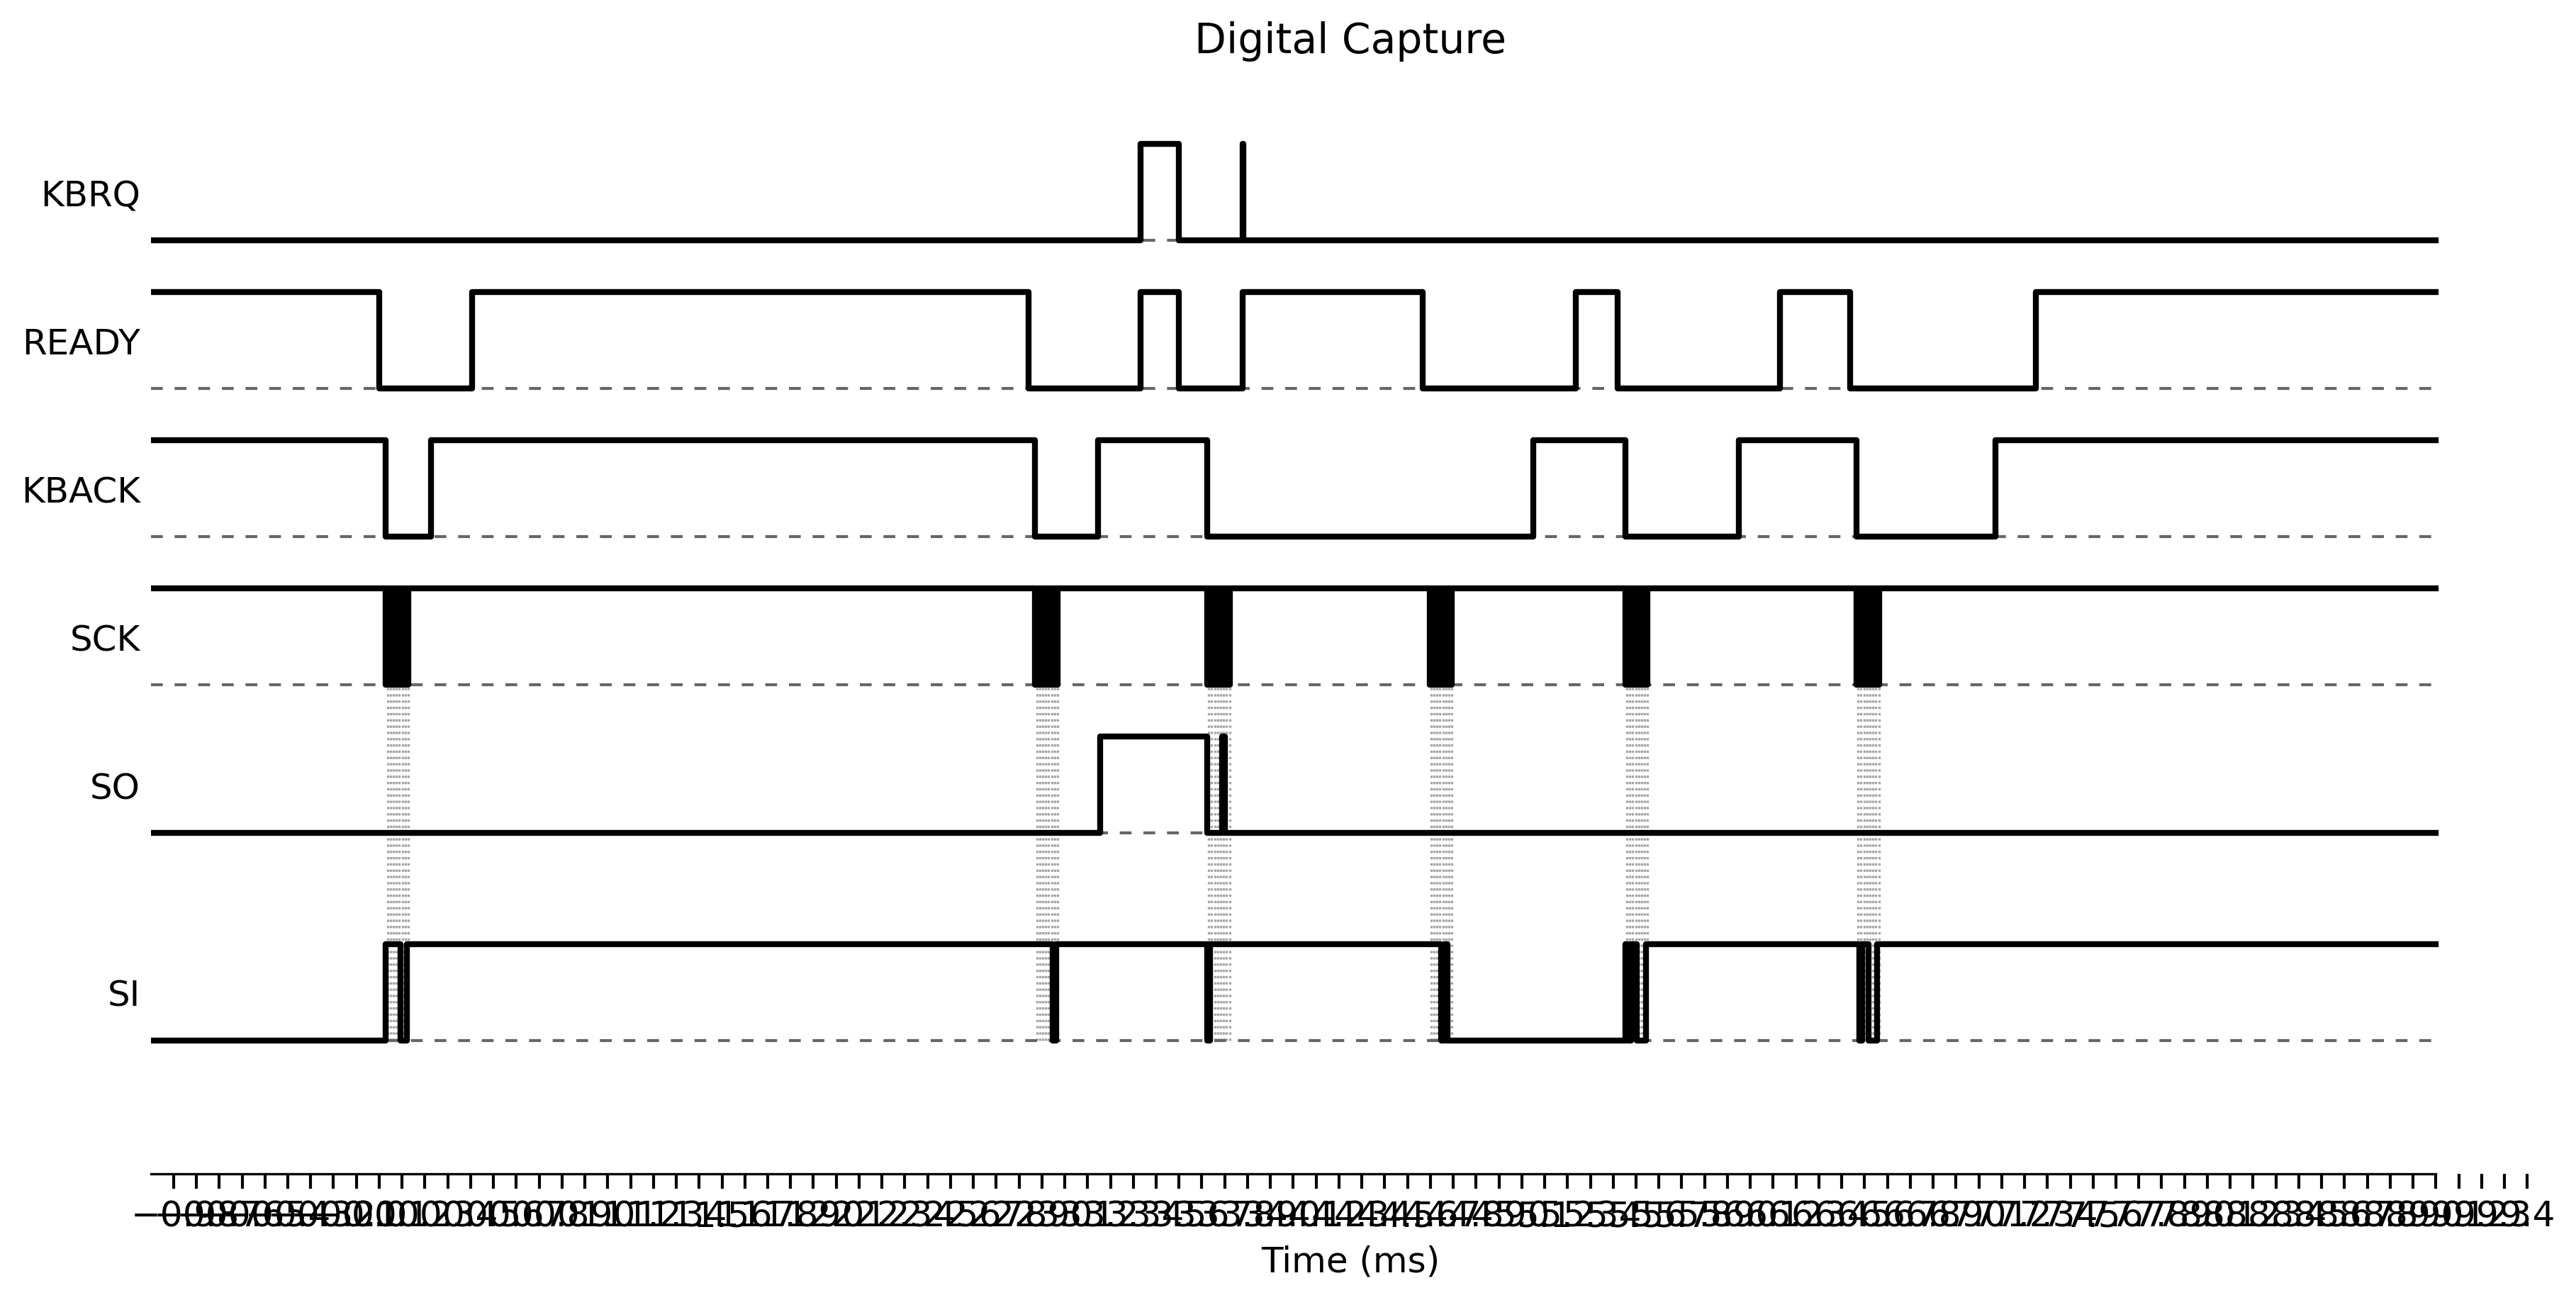

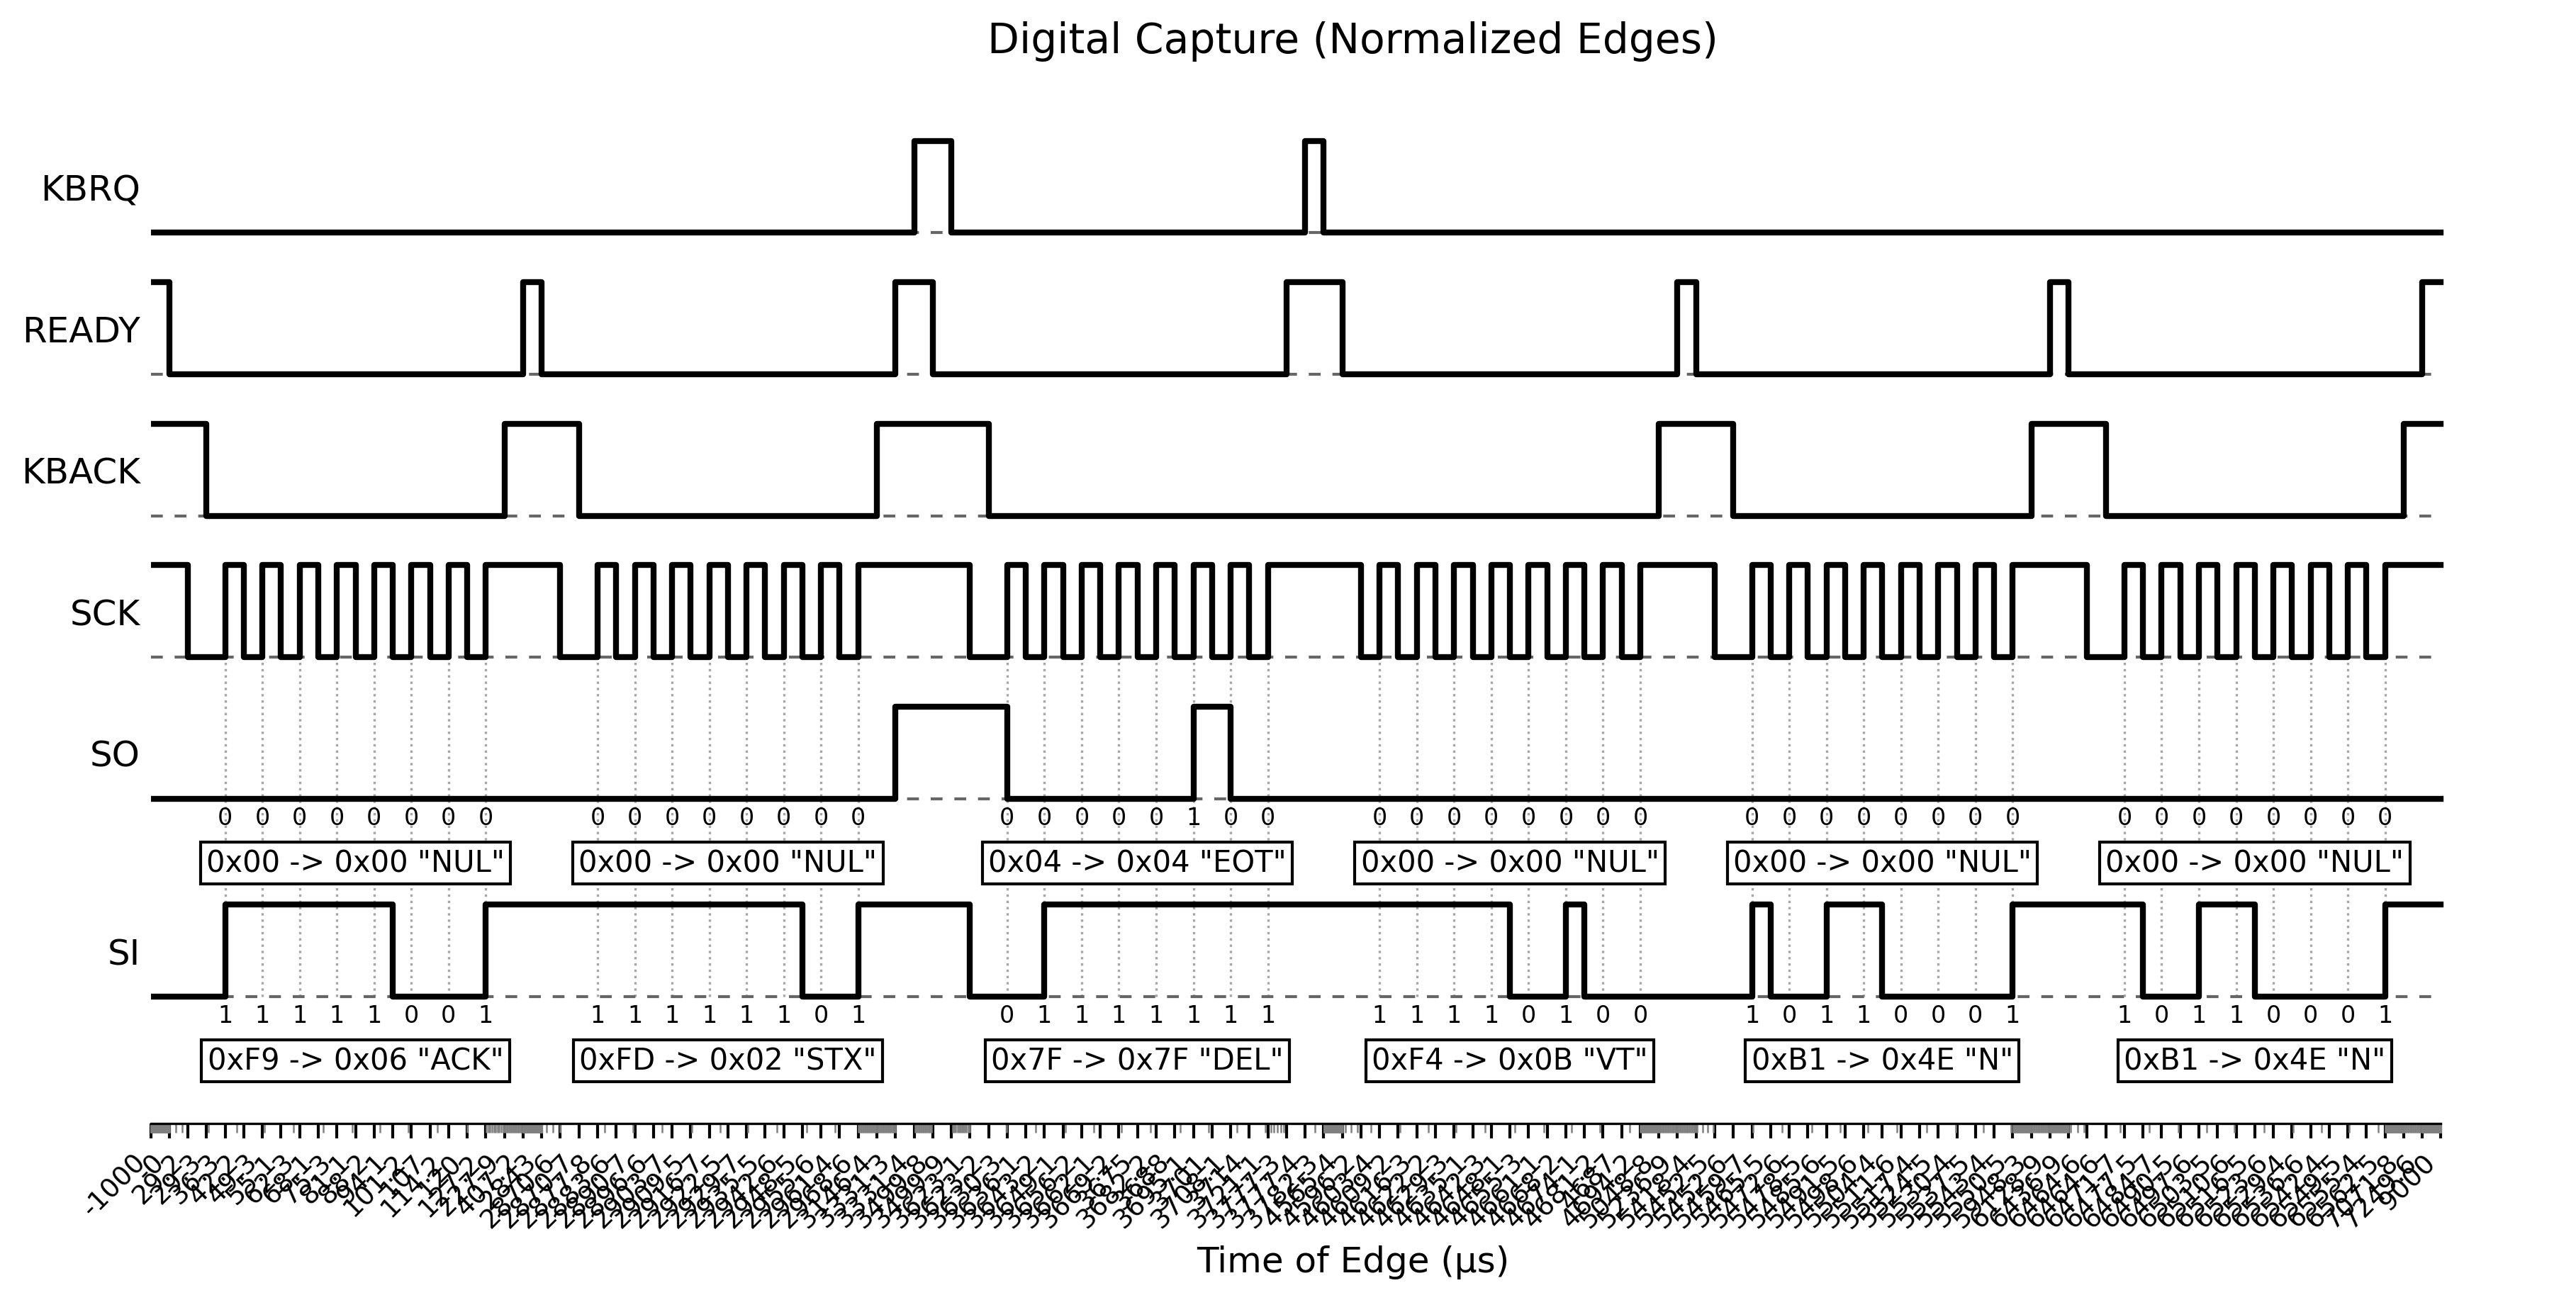

(<Figure size 3600x1800 with 1 Axes>,
 <Axes: title={'center': 'Digital Capture (Normalized Edges)'}, xlabel='Time of Edge (µs)'>)

In [19]:
# Capture Select
# START WITH INTERFACE IN DESELECTED STATE AND TYPEWRITER POWERED OFF AND ON BEFORE!
NAME = "SELECT"
INFO = "Handshake between IF60 and AX20, after Transmission of DC1(Activates SEL Mode) from PC to Interface"

with setup_scope(time_scale=0.1e-2, delay=0.4e-2, trigger_slope="NEGative") as scope:
    with serial.Serial(
        port='/dev/ttyUSB0',
        baudrate=9600,
        bytesize=serial.EIGHTBITS,    # Data Bits: 8
        stopbits=serial.STOPBITS_ONE, # Stop Bits: 1
        parity=serial.PARITY_NONE,    # Parity: None
        rtscts=True,                  # Hardware handshake
        timeout=1
    ) as con:

        # Arm the trigger (non-blocking)
        scope.arm_trigger()
        time.sleep(0.2)

        # DC1 Put IF-60 into Select State
        con.write(bytes([0x11]))
        time.sleep(5)

        # Read the captured data
        time_data, packed, channel_data = scope.read_current_pod_data(pod=1, mode='RAW')

# Create structured Capture with metadata
capture = Capture.from_scope_data(
    time_data, packed, channel_data,
    typewriter=TYPEWRITER,
    interface=INTERFACE,
    name=NAME,
    info=INFO,
    keyboard_setting=KEYBOARD,
    interface_dip_switches=DIP_SWITCHES
)

# Print Captrure Info
print(f"\n{capture.get_info()}")
# Save Capture to file
# filepath = capture.save(directory=f"./signal_captures/{TYPEWRITER}_{INTERFACE}")
print(f"Saved to: {filepath}\n")

# Decode and Debounce Raw Bits
raw_decoder = RawDecoder(channel_data, time_data)
raw_si: RawDecodeResult = raw_decoder.decode(data_ch=0)
raw_so: RawDecodeResult = raw_decoder.decode(data_ch=1)
print(f"RAW-SI: {raw_si}\nRAW-SO: {raw_so}")

decoded_si = BrotherSerialDecoder(raw_si).decode()
decoded_so = BrotherSerialDecoder(raw_so).decode()
print(f"DEC-SI: {decoded_si}\nDEC-SO: {decoded_so}")

# Plot with annotations
annotations = (decoded_si.to_annotations(include_bits=True) + decoded_so.to_annotations(include_bits=True))

plot_digital(time_data, channel_data)
plot_digital_normalized(time_data, channel_data, annotations=annotations)


In [16]:
# Capture ASCII
# START WITH INTERFACE IN SELECTED STATE AND TYPEWRITER POWERED OFF AND ON BEFORE!

import numpy as np
import pandas as pd

with setup_scope(time_scale=2e-4, delay=8e-4, trigger_slope="NEGative") as scope:
    with serial.Serial(
        port='/dev/ttyUSB0',
        baudrate=9600,
        bytesize=serial.EIGHTBITS,    # Data Bits: 8
        stopbits=serial.STOPBITS_ONE, # Stop Bits: 1
        parity=serial.PARITY_NONE,    # Parity: None
        rtscts=True,                  # Hardware handshake
        timeout=1
    ) as con:
        # Array to capture output
        result_list = []

        # Loop all Chars from 33 upto 126
        for i in range(33,127):

            # Special Chars where More is send then one bit. Next cell
            if i in [60, 62, 94]:
                continue

            # Send CR
            con.write(bytes([0x0D]))
            time.sleep(1)

            # Arm the trigger (non-blocking)
            scope.arm_trigger()
            time.sleep(0.2)

            # Send Char
            con.write(bytes([i]))
            time.sleep(1)

            # Read the captured data
            time_data, packed, channel_data = scope.read_current_pod_data(pod=1, mode='NORMal')

            # Create structured Capture with metadata
            capture = Capture.from_scope_data(
                time_data, packed, channel_data,
                typewriter=TYPEWRITER,
                interface=INTERFACE,
                name=f"ASCII_{i}",
                info=f'Transmission from IF60 to AX20, after sending Ascii letter "{chr(i)}" to IF60 from PC ',
                keyboard_setting=KEYBOARD,
                interface_dip_switches=DIP_SWITCHES
            )

            # Print Captrure Info
            # print(f"\n{capture.get_info()}")
            # Save Capture to file
            filepath = capture.save(directory=f"./signal_captures/{TYPEWRITER}_{INTERFACE}")
            # print(f"Saved to: {filepath}\n")

            # Decode and Debounce Raw Bits
            raw_decoder = RawDecoder(channel_data, time_data)
            raw_si: RawDecodeResult = raw_decoder.decode(data_ch=0)

            decoded_si = BrotherSerialDecoder(raw_si).decode()
            decoded_so = BrotherSerialDecoder(raw_so).decode()
            print(f"PC: {i}, IF60: {decoded_si.bytes[0].raw_value} ASCII: {chr(decoded_si.bytes[0].raw_value)}")
            result_list.append((i, decoded_si.bytes[0].raw_value))

    df = pd.DataFrame(result_list, columns=["PC", "IF60"])

Connected to: AGILENT TECHNOLOGIES,MSO7014A,MY49110266,06.20.0000
Digital channels [0, 1, 2, 3, 4, 5] enabled, threshold=2.5V
Edge trigger on D4, slope=NEGative
PC: 33, IF60: 33 ASCII: !
PC: 34, IF60: 64 ASCII: @
PC: 35, IF60: 92 ASCII: \
PC: 36, IF60: 36 ASCII: $
PC: 37, IF60: 37 ASCII: %
PC: 38, IF60: 32 ASCII:  
PC: 39, IF60: 96 ASCII: `
PC: 40, IF60: 42 ASCII: *
PC: 41, IF60: 40 ASCII: (
PC: 42, IF60: 91 ASCII: [
PC: 43, IF60: 93 ASCII: ]
PC: 44, IF60: 44 ASCII: ,
PC: 45, IF60: 47 ASCII: /
PC: 46, IF60: 46 ASCII: .
PC: 47, IF60: 38 ASCII: &
PC: 48, IF60: 48 ASCII: 0
PC: 49, IF60: 49 ASCII: 1
PC: 50, IF60: 50 ASCII: 2
PC: 51, IF60: 51 ASCII: 3
PC: 52, IF60: 52 ASCII: 4
PC: 53, IF60: 53 ASCII: 5
PC: 54, IF60: 54 ASCII: 6
PC: 55, IF60: 55 ASCII: 7
PC: 56, IF60: 56 ASCII: 8
PC: 57, IF60: 57 ASCII: 9
PC: 58, IF60: 62 ASCII: >
PC: 59, IF60: 60 ASCII: <
PC: 60, IF60: 8 ASCII:
PC: 61, IF60: 41 ASCII: )
PC: 62, IF60: 8 ASCII:
PC: 63, IF60: 95 ASCII: _
PC: 64, IF60: 35 ASCII: #
PC: 65, IF60:

Connected to: AGILENT TECHNOLOGIES,MSO7014A,MY49110266,06.20.0000
Digital channels [0, 1, 2, 3, 4, 5] enabled, threshold=2.5V
Edge trigger on D4, slope=NEGative
PC: 60 "<"
RAW-SI: 0b10001000, 0b01011000, 0b10001001
RAW-SO: 0b00000000, 0b00000000, 0b00000000
DEC-SI: w,X,v
DEC-SO: NUL,NUL,NUL


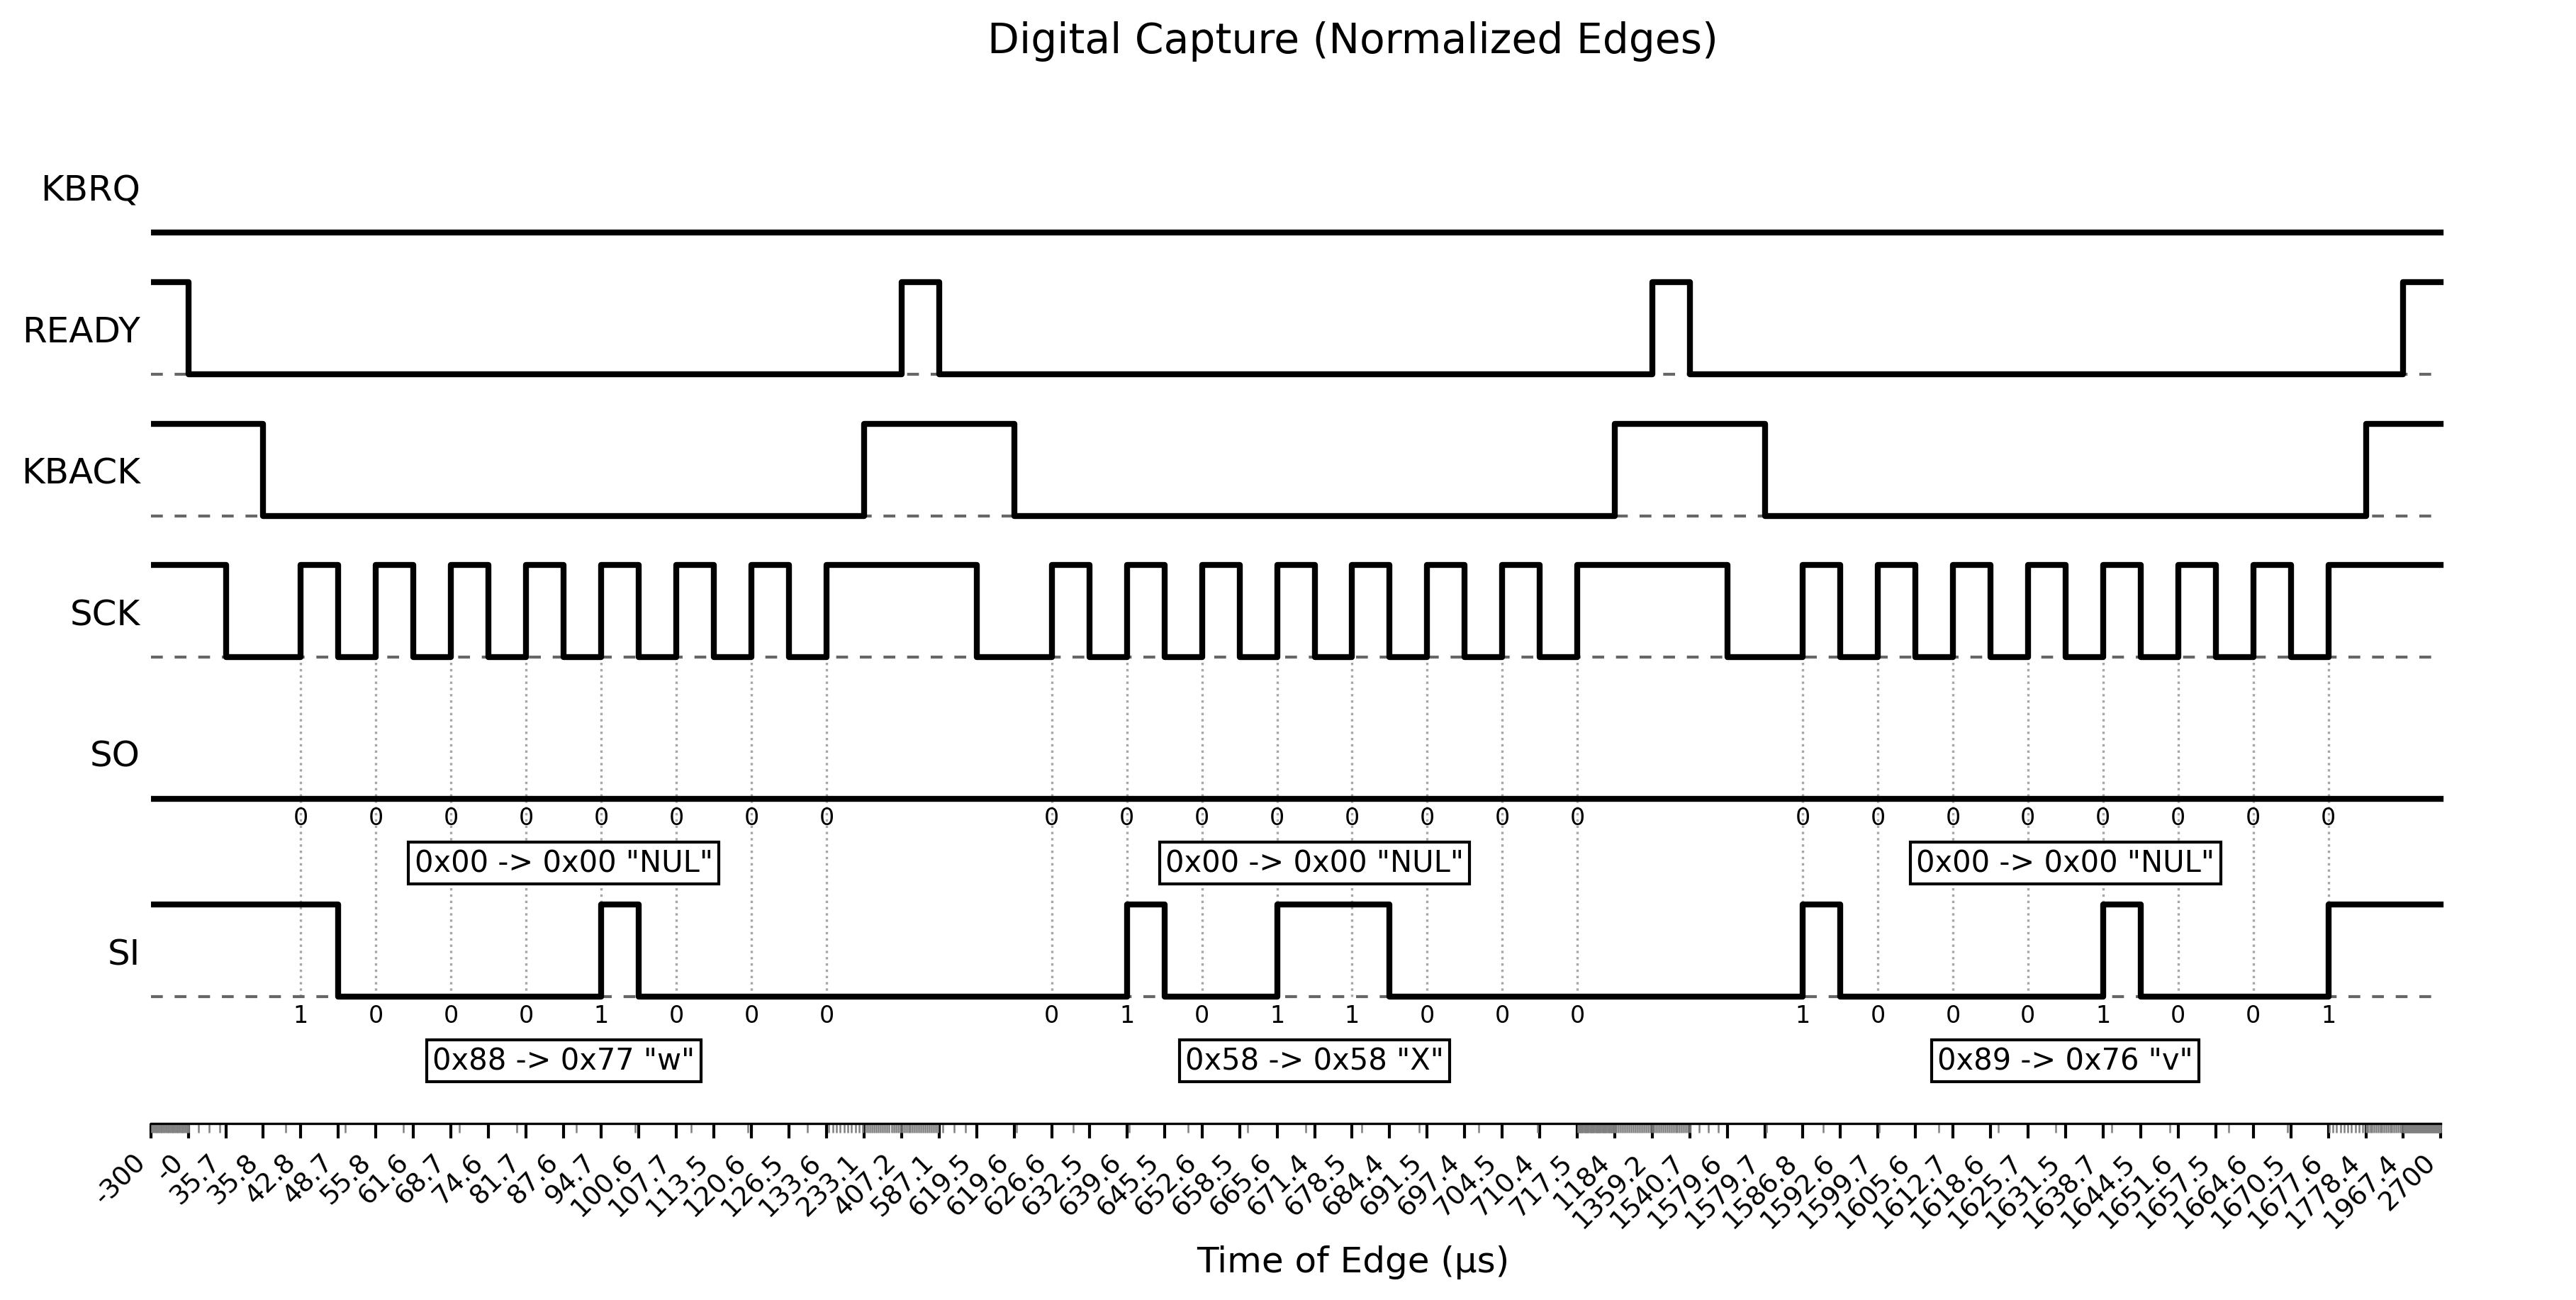

PC: 62 ">"
RAW-SI: 0b10001000, 0b01010110, 0b10001001
RAW-SO: 0b00000000, 0b00000000, 0b00000000
DEC-SI: w,V,v
DEC-SO: NUL,NUL,NUL


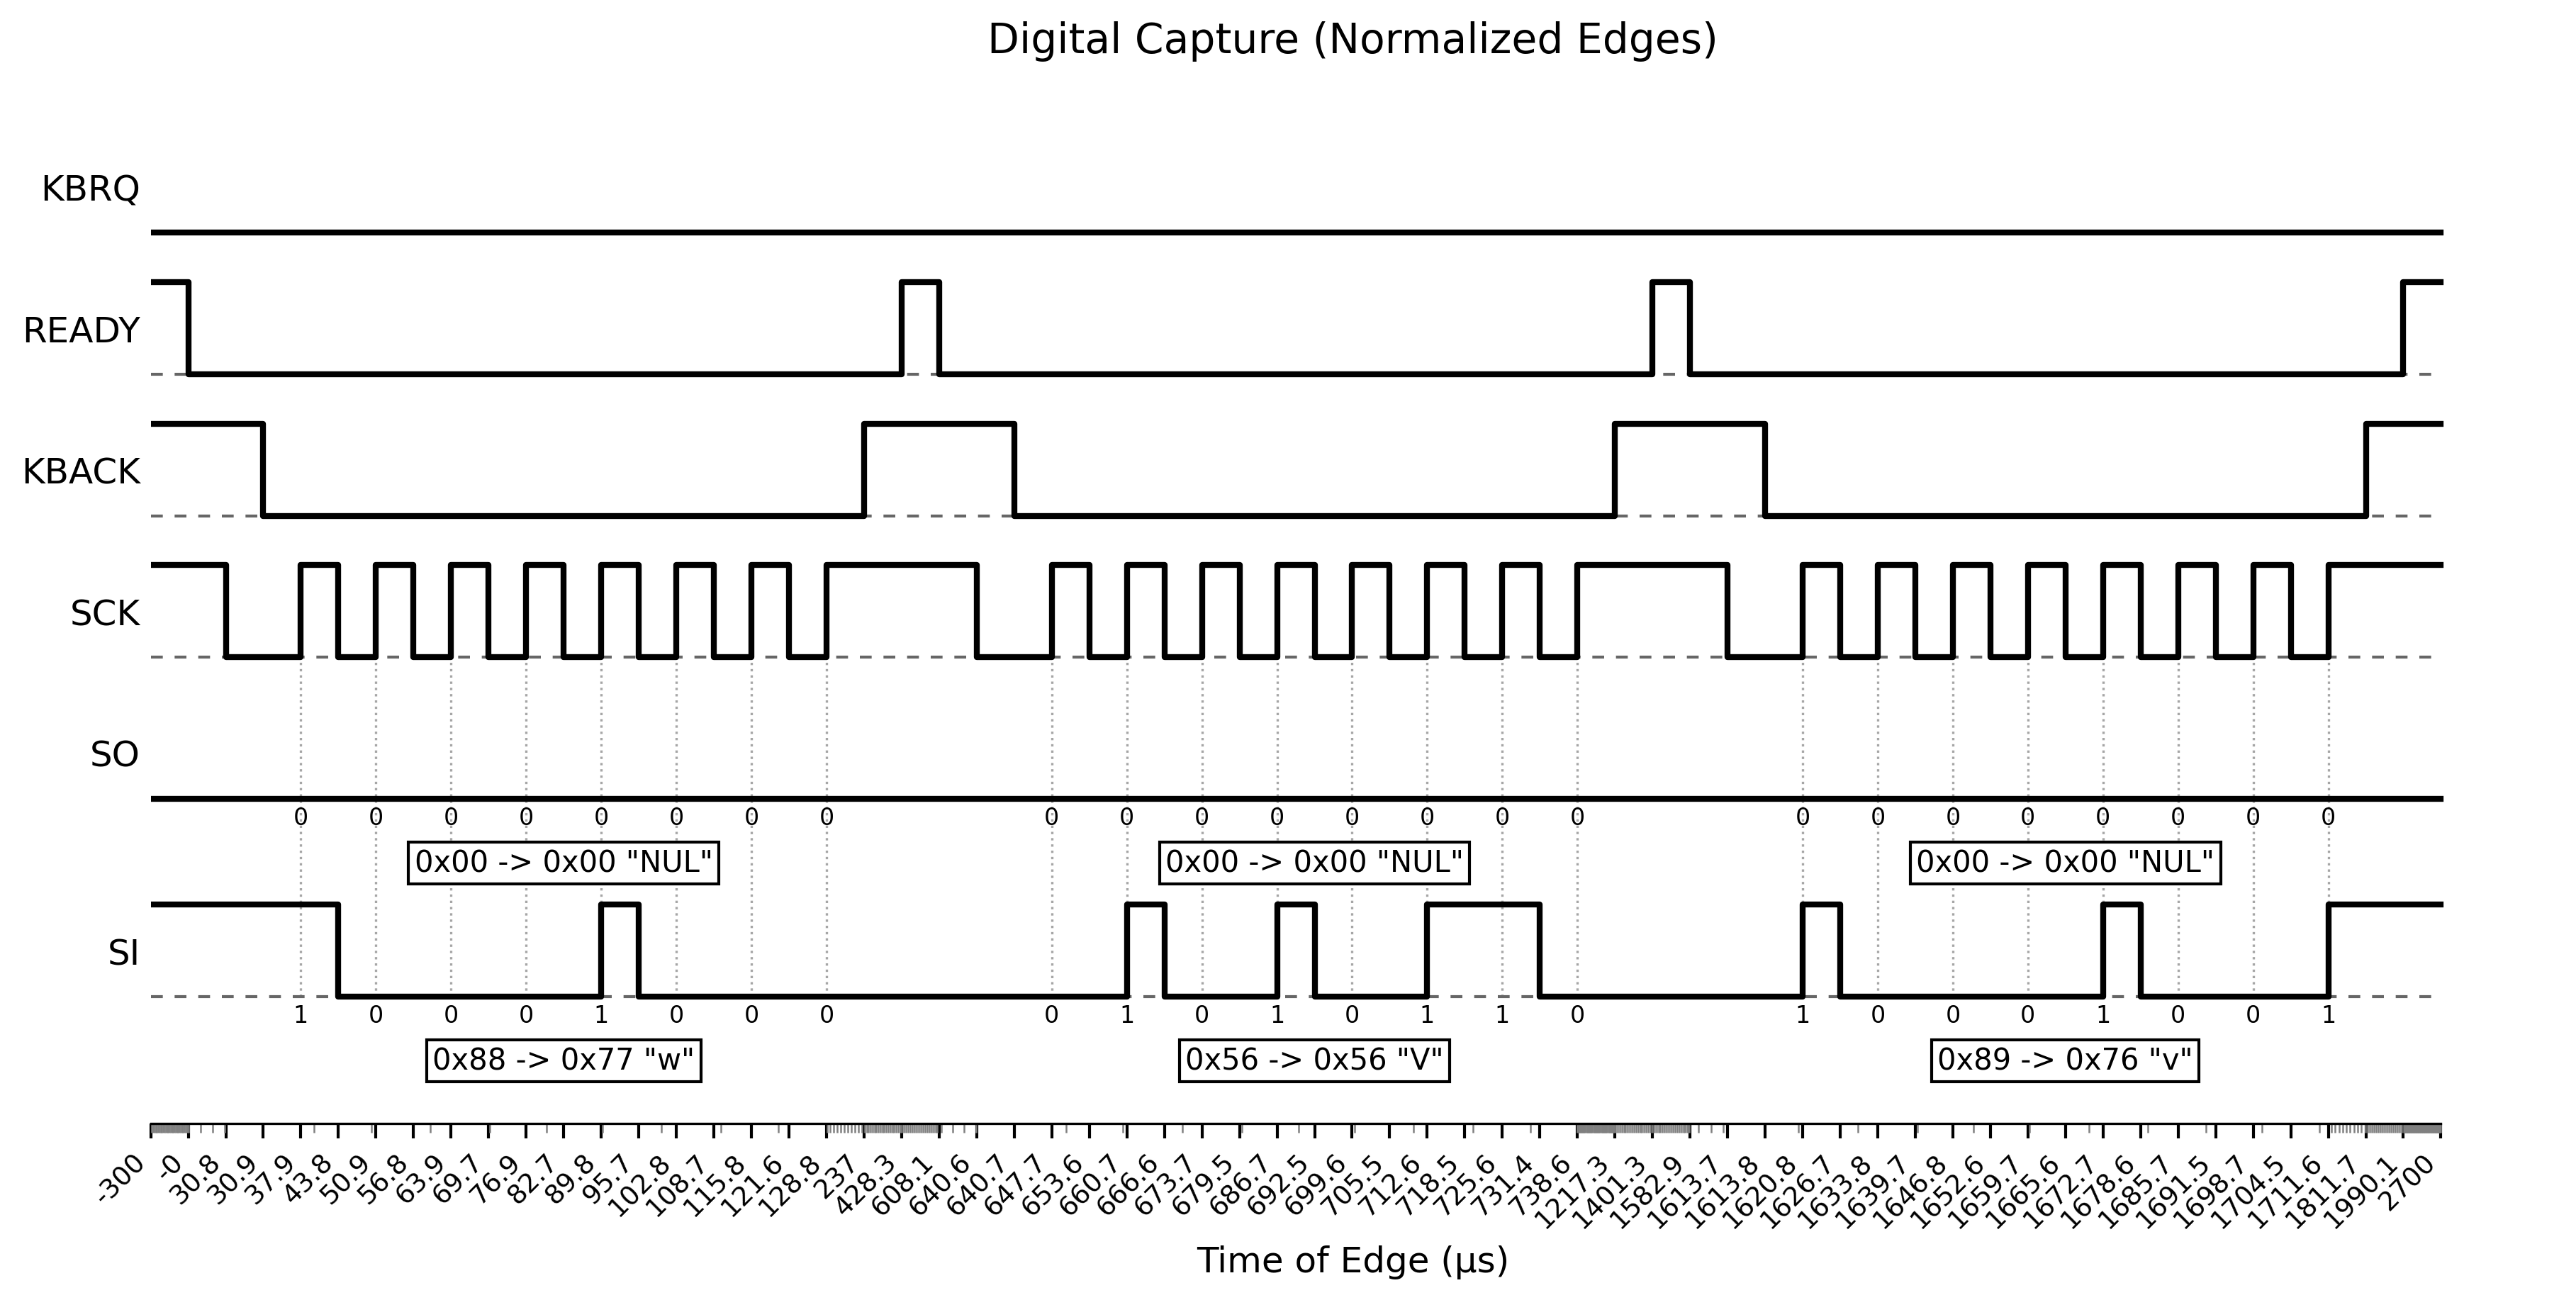

PC: 94 "^"
RAW-SI: 0b10001000, 0b01010111, 0b10001001
RAW-SO: 0b00000000, 0b00000000, 0b00000000
DEC-SI: w,W,v
DEC-SO: NUL,NUL,NUL


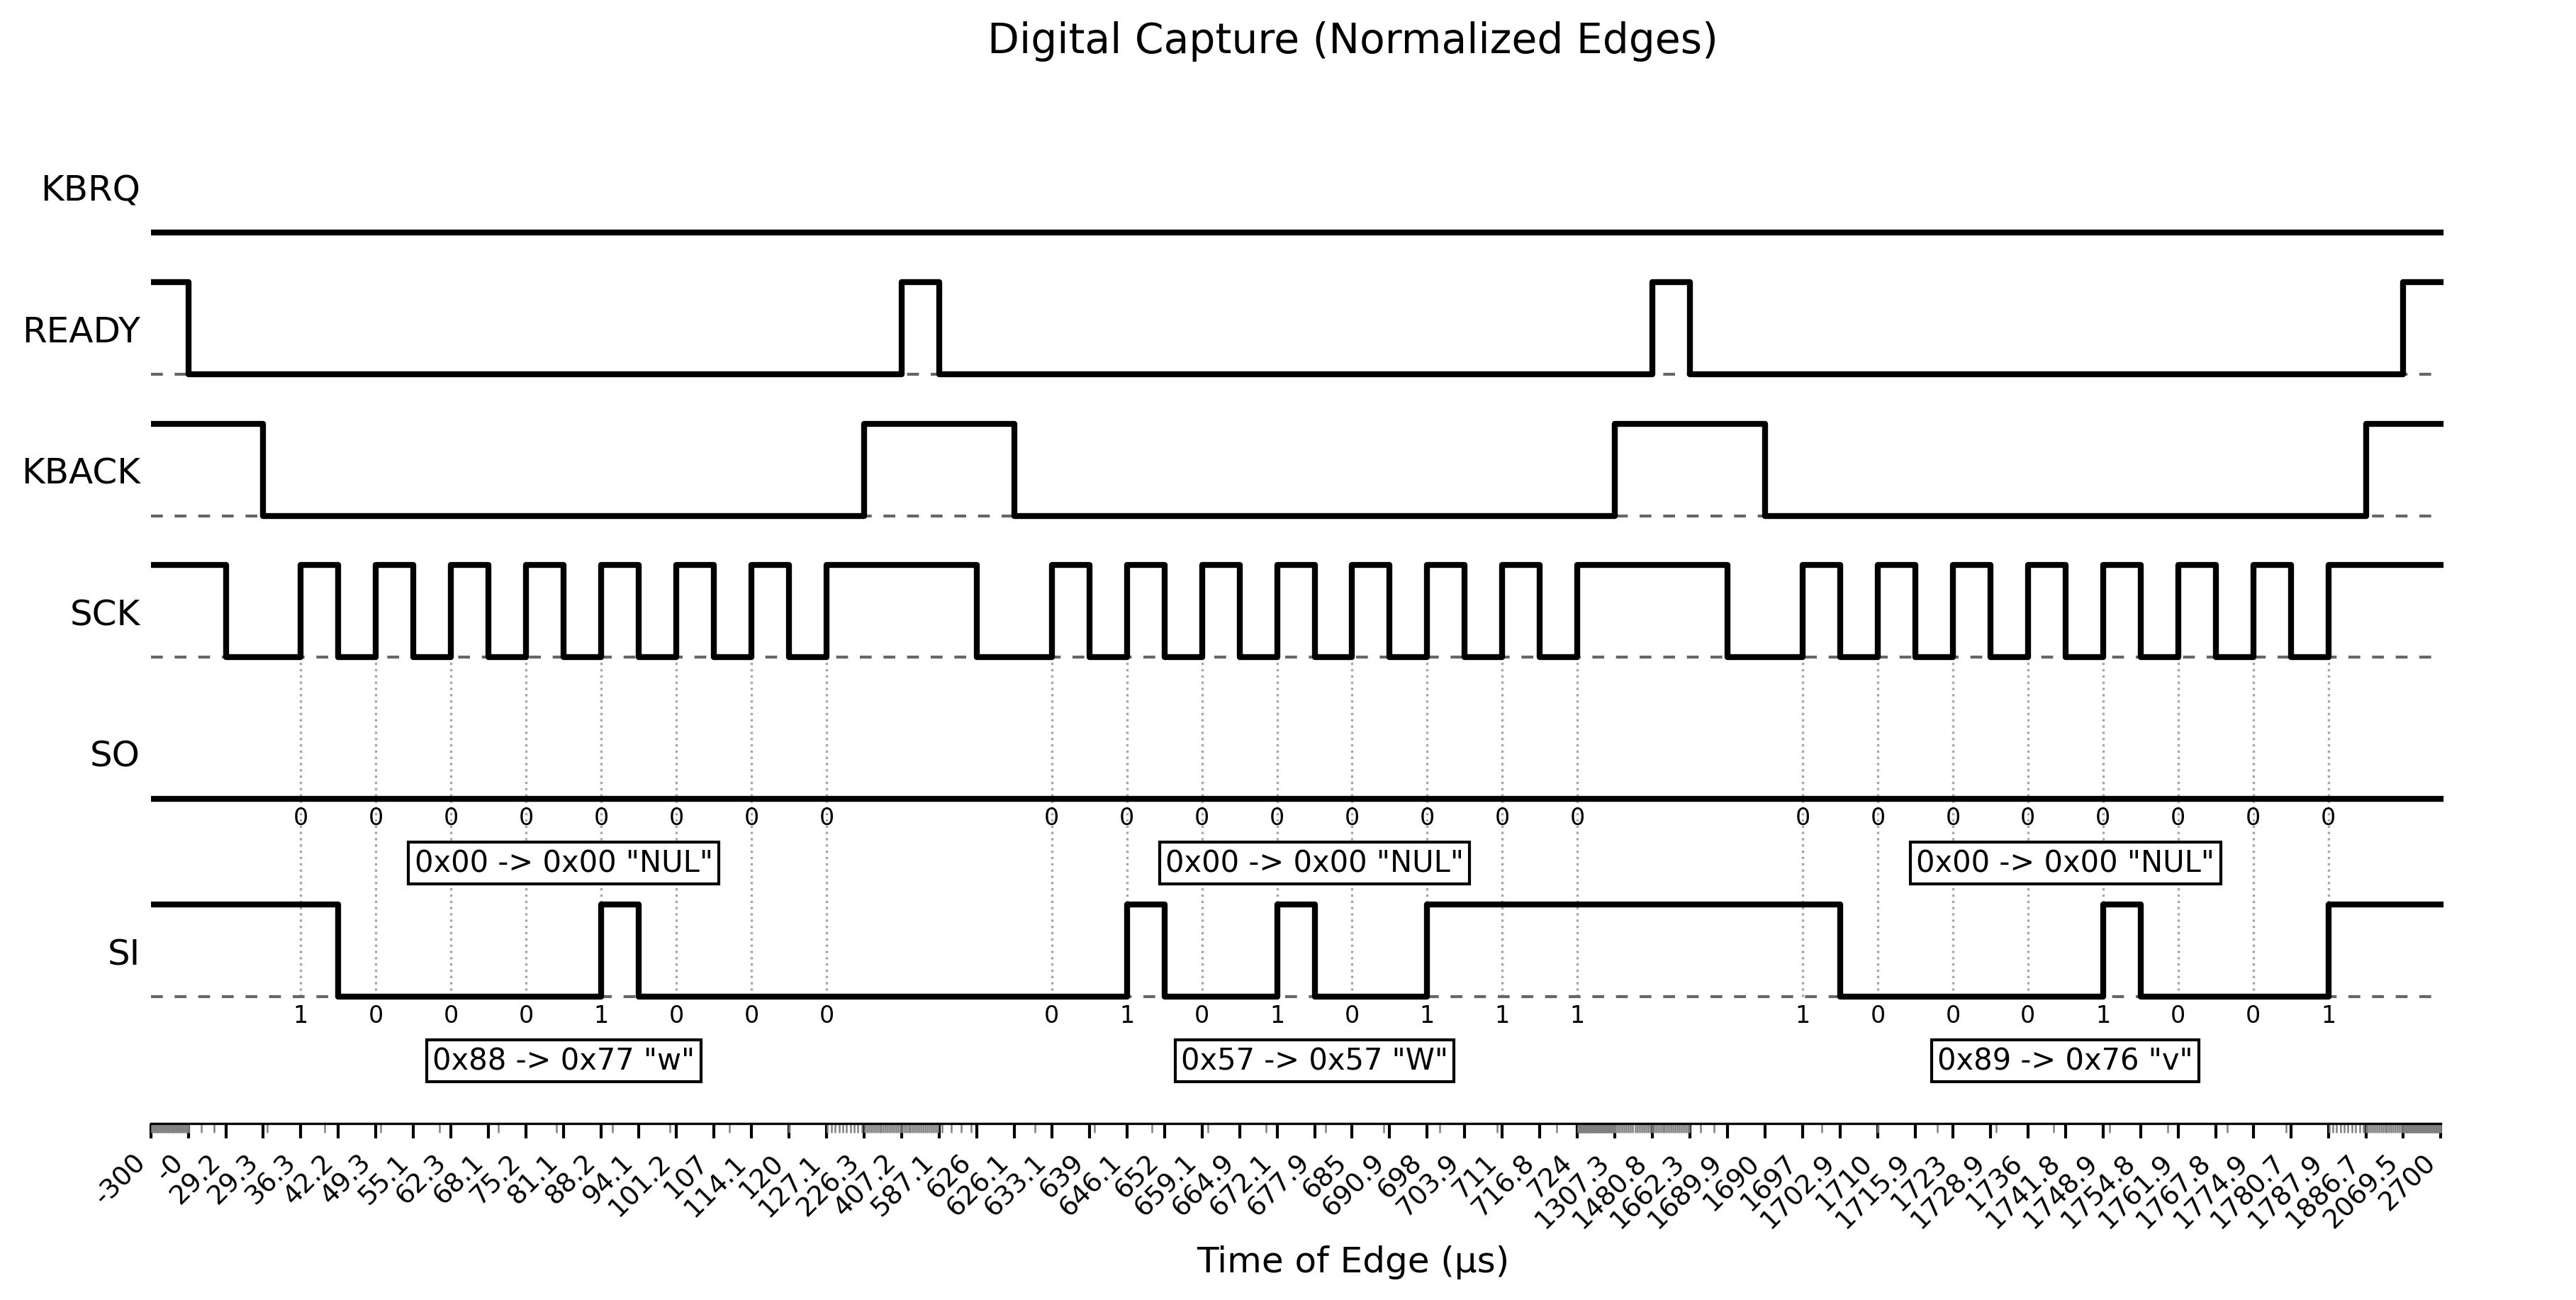

Connection closed


In [2]:
# Capture ABC SPecial
# START WITH INTERFACE IN SELECTED STATE AND TYPEWRITER POWERED OFF AND ON BEFORE!

import numpy as np
import pandas as pd
from analysis_lib.decoder import byte_to_ascii_label

with setup_scope(time_scale=0.3e-3, delay=1.2e-3, trigger_slope="NEGative") as scope:
    with serial.Serial(
        port='/dev/ttyUSB0',
        baudrate=9600,
        bytesize=serial.EIGHTBITS,    # Data Bits: 8
        stopbits=serial.STOPBITS_ONE, # Stop Bits: 1
        parity=serial.PARITY_NONE,    # Parity: None
        rtscts=True,                  # Hardware handshake
        timeout=1
    ) as con:

        # Loop all Chars that where special in the last Transmission
        for i in [60, 62, 94]:
            # Send CR
            con.write(bytes([0x0D]))
            time.sleep(1)

            # Arm the trigger (non-blocking)
            scope.arm_trigger()
            time.sleep(0.2)

            # Send Char
            con.write(bytes([i]))
            time.sleep(1)

            # Read the captured data
            time_data, packed, channel_data = scope.read_current_pod_data(pod=1, mode='RAW')

            # Create structured Capture with metadata
            capture = Capture.from_scope_data(
                time_data, packed, channel_data,
                typewriter=TYPEWRITER,
                interface=INTERFACE,
                name=f"ASCII_{i}_SPECIAL",
                info=f'Transmission from IF60 to AX20, after sending Ascii letter "{chr(i)}" to IF60 from PC. More then One Byte is send',
                keyboard_setting=KEYBOARD,
                interface_dip_switches=DIP_SWITCHES
            )

            # Print Captrure Info
            # print(f"\n{capture.get_info()}")
            # Save Capture to file
            # filepath = capture.save(directory=f"./signal_captures/{TYPEWRITER}_{INTERFACE}")
            # print(f"Saved to: {filepath}\n")

            # Decode and Debounce Raw Bits
            raw_decoder = RawDecoder(channel_data, time_data)
            raw_si: RawDecodeResult = raw_decoder.decode(data_ch=0)
            raw_so: RawDecodeResult = raw_decoder.decode(data_ch=1)
            print(f'PC: {i} "{byte_to_ascii_label(i)}"')
            print(f"RAW-SI: {raw_si}\nRAW-SO: {raw_so}")

            decoded_si = BrotherSerialDecoder(raw_si).decode()
            decoded_so = BrotherSerialDecoder(raw_so).decode()
            print(f"DEC-SI: {decoded_si}\nDEC-SO: {decoded_so}")

            # Plot with annotations
            annotations = (decoded_si.to_annotations(include_bits=True) + decoded_so.to_annotations(include_bits=True))

            # plot_digital(time_data, channel_data)
            plot_digital_normalized(time_data, channel_data, annotations=annotations)

Connected to: AGILENT TECHNOLOGIES,MSO7014A,MY49110266,06.20.0000
Digital channels [0, 1, 2, 3, 4, 5] enabled, threshold=2.5V
Edge trigger on D4, slope=NEGative
Connection closed

Capture: DESELECT
Timestamp: 2026-01-26 18:42:29
Devices: AX20 / IF60
Data: 1.00 MHz, Channels: 0:SI, 1:SO, 2:SCK, 3:KBACK, 4:READY, 5:KBRQ, 6:D6, 7:D7
Notes: Handshake between IF60 and AX20, after Transmission of DC3(Deactivates SEL Mode) from PC to Interface
Saved to: signal_captures/AX20_IF60/AX20_IF60_DESELECT.pkl

RAW-SI: 0b11111000
RAW-SO: 0b00000000
DEC-SI: BEL
DEC-SO: NUL


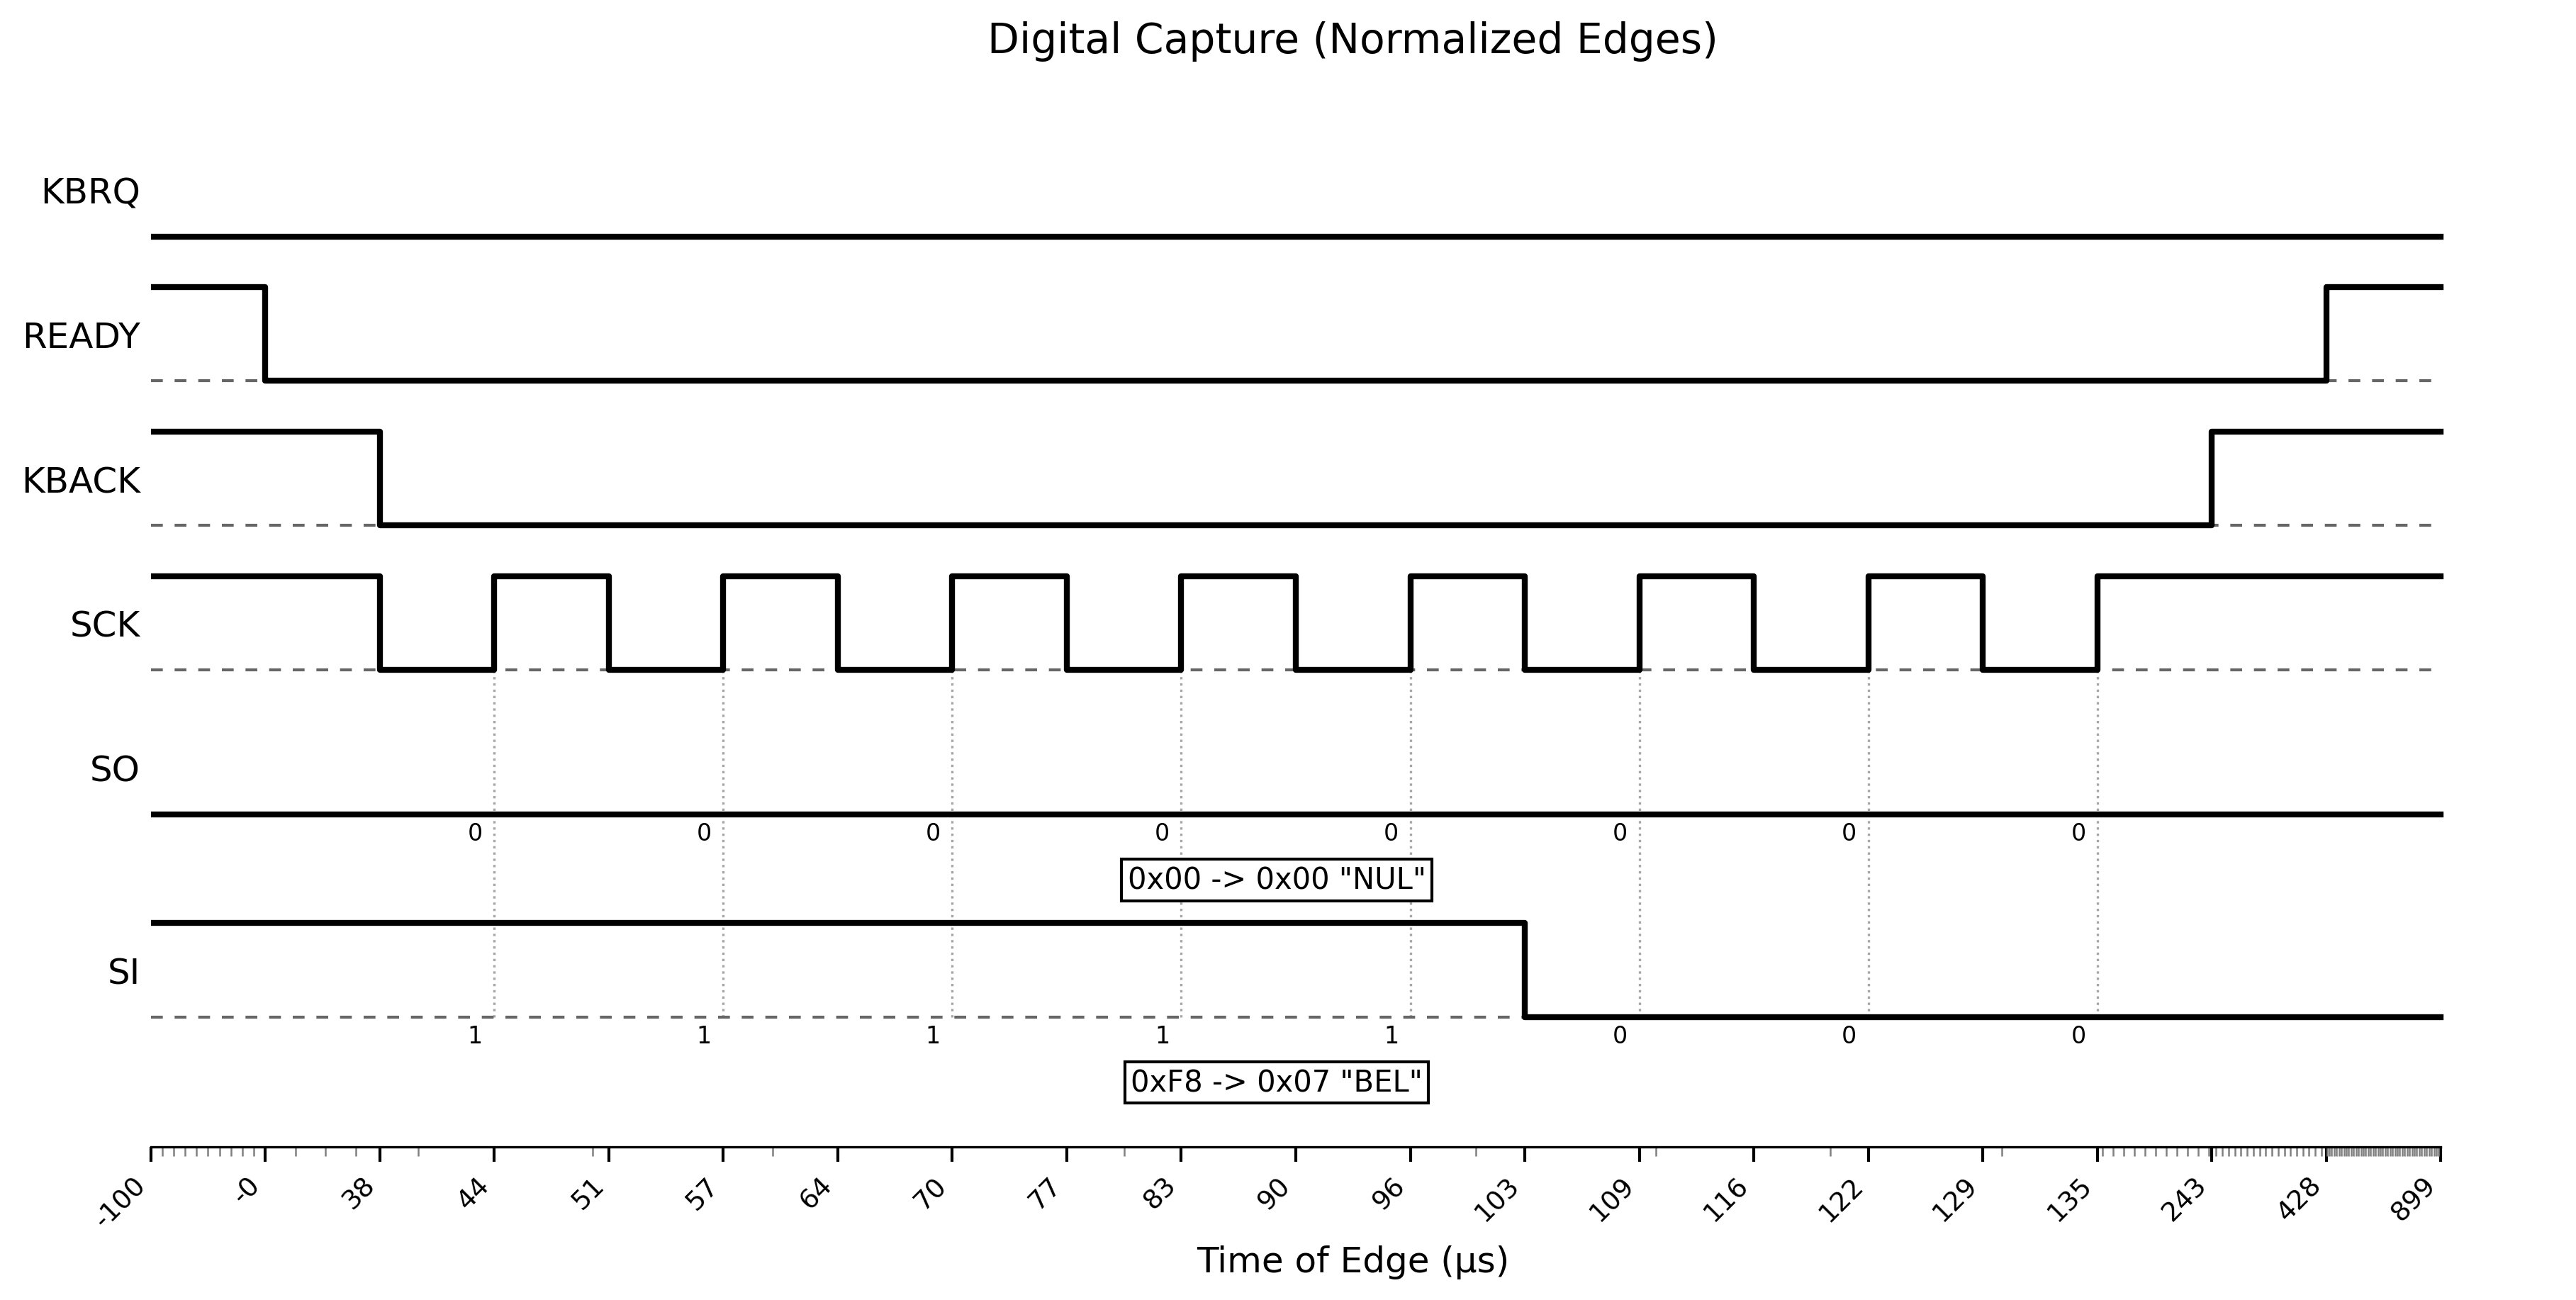

(<Figure size 3600x1800 with 1 Axes>,
 <Axes: title={'center': 'Digital Capture (Normalized Edges)'}, xlabel='Time of Edge (µs)'>)

In [15]:
# Capture DESELECT
# START WITH INTERFACE IN DESELECTED STATE AND TYPEWRITER POWERED OFF AND ON BEFORE!
NAME = "DESELECT"
INFO = "Handshake between IF60 and AX20, after Transmission of DC3(Deactivates SEL Mode) from PC to Interface"

with setup_scope(time_scale=1e-4, delay=4e-4, trigger_slope="NEGative") as scope:
    with serial.Serial(
        port='/dev/ttyUSB0',
        baudrate=9600,
        bytesize=serial.EIGHTBITS,    # Data Bits: 8
        stopbits=serial.STOPBITS_ONE, # Stop Bits: 1
        parity=serial.PARITY_NONE,    # Parity: None
        rtscts=True,                  # Hardware handshake
        timeout=1
    ) as con:

        # Arm the trigger (non-blocking)
        scope.arm_trigger()
        time.sleep(0.2)

        # DC1 Put IF-60 into Select State
        con.write(bytes([0x13]))
        time.sleep(5)

        # Read the captured data
        time_data, packed, channel_data = scope.read_current_pod_data(pod=1, mode='NORMal')

# Create structured Capture with metadata
capture = Capture.from_scope_data(
    time_data, packed, channel_data,
    typewriter=TYPEWRITER,
    interface=INTERFACE,
    name=NAME,
    info=INFO,
    keyboard_setting=KEYBOARD,
    interface_dip_switches=DIP_SWITCHES
)

# Print Captrure Info
print(f"\n{capture.get_info()}")
# Save Capture to file
filepath = capture.save(directory=f"./signal_captures/{TYPEWRITER}_{INTERFACE}")
print(f"Saved to: {filepath}\n")

# Decode and Debounce Raw Bits
raw_decoder = RawDecoder(channel_data, time_data)
raw_si: RawDecodeResult = raw_decoder.decode(data_ch=0)
raw_so: RawDecodeResult = raw_decoder.decode(data_ch=1)
print(f"RAW-SI: {raw_si}\nRAW-SO: {raw_so}")

decoded_si = BrotherSerialDecoder(raw_si).decode()
decoded_so = BrotherSerialDecoder(raw_so).decode()
print(f"DEC-SI: {decoded_si}\nDEC-SO: {decoded_so}")

# Plot with annotations
annotations = (decoded_si.to_annotations(include_bits=True) + decoded_so.to_annotations(include_bits=True))

# plot_digital(time_data, channel_data)
plot_digital_normalized(time_data, channel_data, annotations=annotations)
